# Abstract

When prospective borrowers request loans from banks, the bank is faced with a fiscal decision to provide the loan or reject the loan. Should the borrower default on the loan, the bank will likely take a loss. However, should they repay the loan, the bank will turn a profit through interest. This blog post will explore one methodology for an automated decision making process for granting or rejecting loans, using weights derived from a machine learning model. These weights will be used to determine the optimal threshold at which the bank should grant or deny loans, assuming we want to optimize for profit. The fairness of this model will then be examined, with a discussion of whether it is acceptable for certain people to have an easier time accessing credit over others.

# Exploration

We will be working with a dataset of borrowers, with a target variable of whether they ended up defaulting on the loan or not. First, let's take a look at the data:

In [1]:
import pandas as pd
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)

In [2]:
df_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,43200,RENT,NaN,VENTURE,B,1200,9.91,0,0.03,N,4
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10


In this dataframe, `loan_status` is the target variable, which is a 0 if the loan was repaid, and a 1 if the borrower defaulted on the loan. We will therefore need to split this column from the rest of the data. We will also drop the `loan_grade` column, as that is the bank's evaluation of how likely the borrower is to repay the loan (which is what we want to figure out ourselves!). Lastly, we will drop any columns with missing data, and convert any qualitative columns to one-hot columns so that our eventual machine learning model will have an easier time with the features.

In [3]:
# Pre-processing
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df_train["loan_status"]) # for 0, 1, 2 etc. cols

def prepare_data(df):
  df = df.dropna()
  y = le.transform(df["loan_status"])
  df = df.drop(["loan_status"], axis = 1)
  df = df.drop(["loan_grade"], axis = 1)
  df = pd.get_dummies(df, dtype=int)
  return df, y

X_train, y_train = prepare_data(df_train)
X_train

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_N,cb_person_default_on_file_Y
1,27,98000,3.0,11750,13.47,0.12,6,0,0,0,1,0,1,0,0,0,0,0,1
2,22,36996,5.0,10000,7.51,0.27,4,0,0,0,1,0,1,0,0,0,0,1,0
3,24,26000,2.0,1325,12.87,0.05,4,0,0,0,1,0,0,0,1,0,0,1,0
4,29,53004,2.0,15000,9.63,0.28,10,1,0,0,0,0,0,1,0,0,0,1,0
6,21,21700,2.0,5500,14.91,0.25,2,0,0,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26059,36,150000,8.0,3000,7.29,0.02,17,1,0,0,0,0,1,0,0,0,0,1,0
26060,23,48000,1.0,4325,5.42,0.09,4,0,0,0,1,0,0,0,0,0,1,1,0
26061,22,60000,0.0,15000,11.71,0.25,4,0,0,0,1,0,0,0,1,0,0,1,0
26062,30,144000,12.0,35000,12.68,0.24,8,1,0,0,0,0,0,0,0,1,0,1,0


Now we are ready to begin exploring the data. It will be useful to have some idea of potential correlations between features before training the model, as this will help us understand the results we obtain. One potential correlation I thought would be interesting to look at is what interest rate the bank offers a borrower as it relates to the length of the borrower's last employment. Let's first take a look at the minimum, maximum, and average of these features.

In [4]:
print("min interest rate: ", X_train["loan_int_rate"].min())
print("max interest rate: ", X_train["loan_int_rate"].max())
print("mean interest rate: ", X_train["loan_int_rate"].mean())

print("\n")
print("min emp length: ", X_train["person_emp_length"].min())
print("max emp length: ", X_train["person_emp_length"].max())
print("mean emp length: ", X_train["person_emp_length"].mean())

min interest rate:  5.42
max interest rate:  23.22
mean interest rate:  11.03494608634915


min emp length:  0.0
max emp length:  123.0
mean emp length:  4.787357576286724


The minimum interest rate that the bank offered a borrower was 5.42%, the maximum was 23.22%, and the mean falls at around 11%. The minimum last employment length was zero, which makes sense, as some borrowers have likely never worked before. The maximum was 123 years, which is almost certainly an error in the data, especially considering that the average was about 4.75 years. For the sake of simplicity, we will consider last employment lengths from 0 to 20 years, and use a chart to visualize what proportion of different employment length buckets received low interest rates versus high interest rates. The following code block generates Figure 1, which shows this relationship.

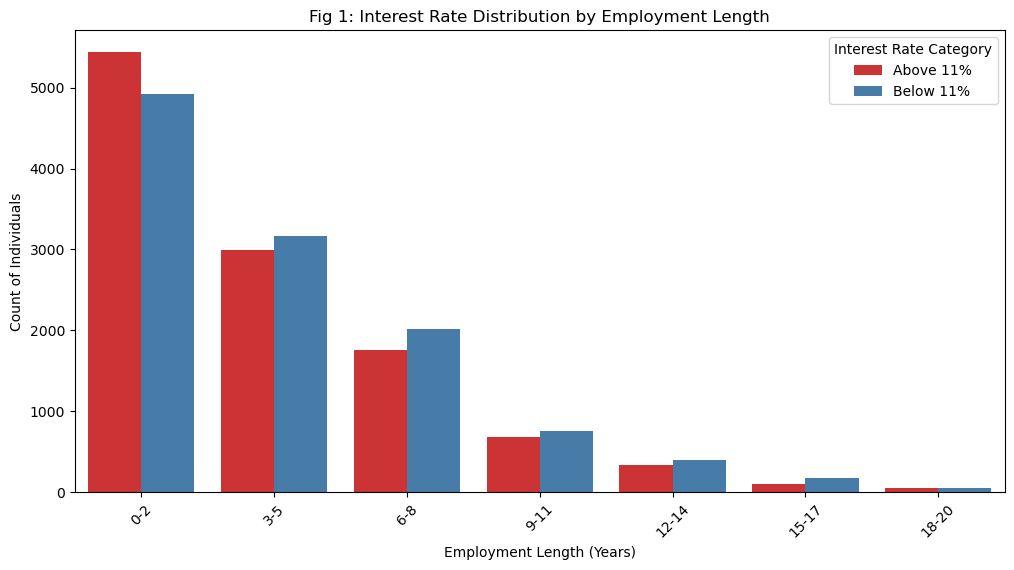

In [5]:
# Visualization 1
import seaborn as sns
import matplotlib.pyplot as plt

X_train_dv = X_train.copy()

# Define employment length bins
emp_bins = list(range(0, 24, 3))  # Bins: [0-2, 3-5, 6-8, ..., 18-20]
emp_labels = ["0-2", "3-5", "6-8", "9-11", "12-14", "15-17", "18-20"]

# Categorize employment length into bins
X_train_dv["emp_length_group"] = pd.cut(X_train_dv["person_emp_length"], bins=emp_bins, labels=emp_labels, right=True, include_lowest=True)

# Categorize interest rates
X_train_dv["rate_category"] = X_train_dv["loan_int_rate"].apply(lambda x: "Below 11%" if x < 11 else "Above 11%")

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.countplot(
    data=X_train_dv, 
    x="emp_length_group", 
    hue="rate_category",
    palette="Set1"
)

# Customize labels
plt.xlabel("Employment Length (Years)")
plt.ylabel("Count of Individuals")
plt.title("Fig 1: Interest Rate Distribution by Employment Length")
plt.legend(title="Interest Rate Category")
plt.xticks(rotation=45)

plt.show()

As we can see, borrowers with last employment lengths of 0-2 years receive above average interest rates more often than borrowers with longer last employment lengths. This suggests that borrowers who have had strong careers are offered more favorable deals than borrowers who have not worked stable for lengthy periods of time. The bank may do this as a form of risk protection, as a higher interest rate will encourage a borrower to repay their loan in a timely manner. However, this may have disparate impacts on people whose last employment length was low, as not having had a long-term job suggests that they may lack savings. Taking on a high-interest loan may be unviable for them, so this distribution may impact some borrowers' ability to access affordable credit.

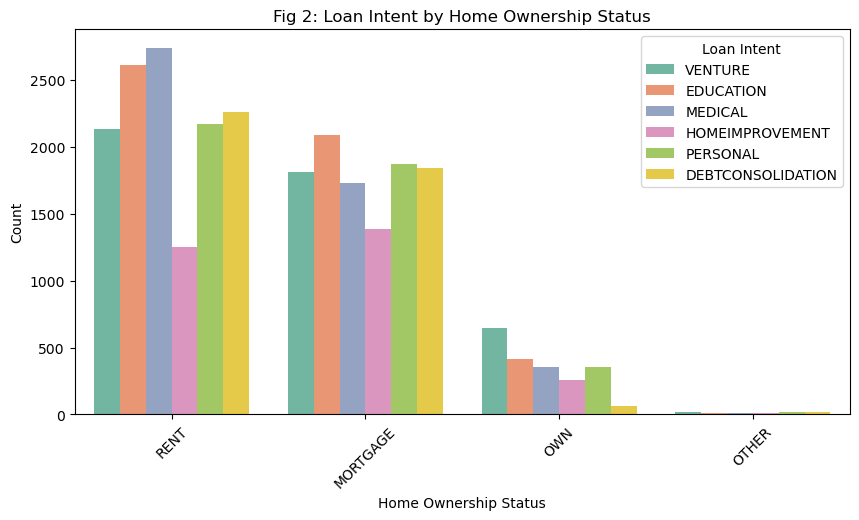

In [24]:
# Visualization 2
plt.figure(figsize=(10, 5))
sns.countplot(
    data=df_train, 
    x="person_home_ownership", 
    hue="loan_intent",
    palette="Set2"
)

plt.xlabel("Home Ownership Status")
plt.ylabel("Count")
plt.title("Fig 2: Loan Intent by Home Ownership Status")
plt.legend(title="Loan Intent")
plt.xticks(rotation=45)
plt.show()


Figure 2 plots the relation between loan intent and home ownership status. Renters have the highest rates of education and medical loans, mortgagers have a high rate of education loans as well as personal and debt consolidation loans. Home owners, on the other hand, have disproportionately high rates of venture loans. Venture loans, importantly, are the type of loan most likely to imply that its use is to expand the borrower's capital even further. Medical loans or debt consolidation loans may be necessary for the borrower's continued well-being, whereas venture loans are likely optional loans being taken because there is an opportunity for fiscal gain. What this suggests is that home renters or mortgagers may be in a less stable position than homeowners, which means that their loans are more focused on continued survival rather than development of wealth. If it turns out that venture loans are more likely to be repaid than medical loans, for example, this may lead a profit-driven bank to provide fewer essential loans and more investment loans, which can have strong negative impacts on those in need.

In [7]:
# Summary Table
summary_table = df_train.groupby("cb_person_default_on_file").aggregate(
    Mean_Income_USD=("person_income", "mean"),
    Median_Income_USD=("person_income", "median"),
    Mean_Loan_Size_USD=("loan_amnt", "mean"),
    Median_Loan_Size_USD=("loan_amnt", "median")
)

# Display the table
print(summary_table)

                           Mean_Income_USD  Median_Income_USD  \
cb_person_default_on_file                                       
N                             65990.726858            55315.0   
Y                             65900.076251            54000.0   

                           Mean_Loan_Size_USD  Median_Loan_Size_USD  
cb_person_default_on_file                                            
N                                 9464.480849                8000.0  
Y                                10062.338868                8100.0  


The summary table above displays the mean and median income as well as mean and median loan size, organized by whether the borrowers had a default on file or not. My suspicion before making this table was that borrowers with a default on file may have lower income than borrowers without one, and that borrowers with a default on file may only be approved for smaller loans than borrowers without one. Interestingly, neither of my predicted relationships seem to hold, as mean and median income are very similar across both categories, and mean loan size is actually higher for those with a default on file than those without one. This may suggest that having a default on file is not a significant factor in the bank's decision making, and that having a default on file is not correlated with income. Therefore, our machine learning model may place relatively little weight on loan size or income.

# Modeling

Now it is time to train a model to predict whether a borrower will default or not. This will result in a vector of weights $\mathbf{w}$, which we can then use to decide whether loans should be approved or not.

To begin, we'll need to choose what features we want to use to train the model-- for simplicity, we can simply provide the model with all of the features as a starting point, and evaluate its accuracy. In many cases, this approach is effective out of the box, and won't require any further selection of features. 

The following code block simply trains a LogisticRegression on all columns of X_train (except `loan_grade` of course, since it was dropped earlier). The only further transformation we will apply to the data is a logorithmic scale to income, as the wide range of values present in the income column is cumbersome for the LogisticRegression. By scaling it, the LR can converge more efficiently. We will then use 5-fold cross validation to simulate a test of the model, and evaluate the average accuracy. The output will contain some warnings regarding the number of iterations, due to the scale of the data being very large-- we could increase the number of iterations to account for this, but this process is a good starting point, and leaving the number of iterations at default maintains a low running time.

In [60]:
# Train an LR using all features except loan grade

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import numpy as np

X_train["person_income"] = np.log1p(X_train["person_income"])  # log scale person income due to wide range

LR = LogisticRegression()
LR.fit(X_train, y_train)
scores = cross_val_score(LR, X_train, y_train, cv=5) # Using 5-fold cross validation

/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

In [9]:
print(np.mean(scores))

0.8159947464862315


The model achieved an average accuracy of 81.6%, which is reasonably accurate for this sort of prediction. Embedded in this model is our vector of weights $\mathbf{w}$, which we can use to compute a borrower score for each borrower in the training set. The LR uses this score to make a prediction on its own, but we will manually use the vector to make our own prediction by determing the cutoff point at which we can maximize profit. For simplicity, I will use the provided mathematical model, where the profits for the case where the loan is repaid and the case where the loan is defaulted are as follows:

$$
\text{Repaid Profit} = \text{Loan Amount} \times (1 + 0.25 \times \text{Loan Interest Rate})^{10} - \text{Loan Amount}
$$

$$
\text{Defaulted 'Profit'} = \text{Loan Amount} \times (1 + 0.25 \times \text{Loan Interest Rate})^{3} - 1.7 \times \text{Loan Amount}
$$

The following code block uses this mathematical model to determine the optimal threshold at which we should stop accepting loans. It first calculates the score for each borrower, then creates a new dataframe which contains the borrower's score, the outcome of their loan (whether they repaid it or defaulted on it), and the profit made from their loan in either case as determined by the mathematical model above. It then adds a new column to the dataframe, expected profit, which contains the actual profit made if this loan is accepted based on the outcome of the loan and the profit calculation. Lastly, it calculates the cumulative profit made if we accept all borrowers above every possible threshold, then prints out the threshold at which the maximum cumulative profit is made, as well as what that profit is, and what the profit per borrower is.

In [43]:
# Find the optimal profit threshold based on the predictions made by the LR
borrower_scores = X_train.values @ LR.coef_.ravel() # ravel method fixes dimensions of coef vector
borrower_scores = borrower_scores.flatten() # flatten method converts ~20000 * 1 matrix to a 1d array of length ~20000

repay_profit = X_train["loan_amnt"] * (1 + 0.25*(X_train["loan_int_rate"]/100))**10 - X_train["loan_amnt"]
default_profit = X_train["loan_amnt"] * (1 + 0.25 *(X_train["loan_int_rate"]/100))**3 - 1.7*X_train["loan_amnt"]

df_scores = pd.DataFrame({
    "score": borrower_scores,
    "outcome": y_train,
    "repay_profit": repay_profit,
    "default_profit": default_profit
})

df_scores = df_scores.sort_values(by="score", ascending=False).reset_index(drop=True) # sort so we can test thresholds from top to bottom

df_scores["expected_profit"] = df_scores["outcome"] * df_scores["repay_profit"] + (1 - df_scores["outcome"]) * df_scores["default_profit"]
df_scores = df_scores.sort_values(by="score")
sorted_scores = df_scores["score"].values
sorted_profits = df_scores["expected_profit"].values

# Compute cumulative profit in reverse order
cumulative_profit = np.cumsum(sorted_profits[::-1])[::-1] # cumulative profit across all approved borrowers
num_borrowers = np.arange(len(sorted_scores), 0, -1) # total num of borrowers
profit_per_borrower = cumulative_profit / num_borrowers  

# Find the threshold that maximizes profit
optimal_index = np.argmax(cumulative_profit)
optimal_threshold = sorted_scores[optimal_index]
optimal_profit = cumulative_profit[optimal_index]
optimal_PPB = profit_per_borrower[optimal_index]

print("Optimal Threshold: ", optimal_threshold)
print("Optimal Profit: ", optimal_profit)
print("Optimal PPB: ", optimal_PPB)

Optimal Threshold:  0.14241452471915317
Optimal Profit:  3313401.632051698
Optimal PPB:  2754.2823209074795


This model imputes an optimal score threshold of about 0.14, at which the profit on the training set is calculated to be 3.3 million dollars, with a profit per borrower of $2754.28. The following code block visualizes all possible thresholds as a line, showing clearly where the maxima lies.

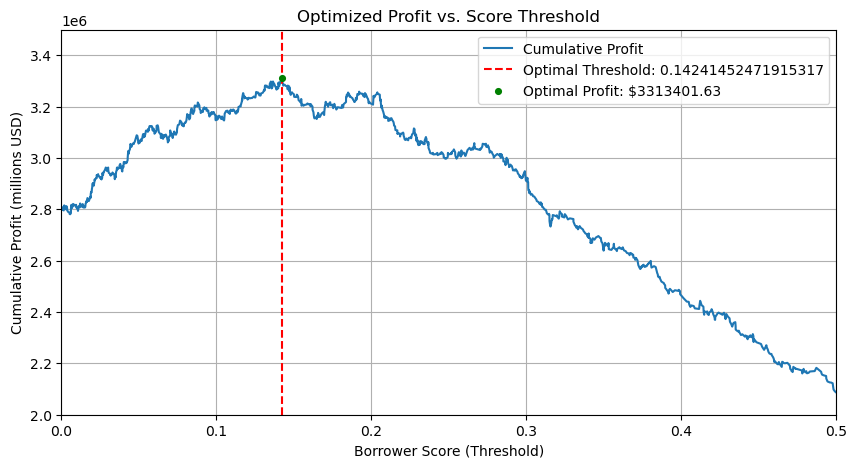

In [53]:
plt.figure(figsize=(10, 5))
plt.plot(sorted_scores, cumulative_profit, label="Cumulative Profit")
label1 = ("Optimal Threshold: " + str(float(optimal_threshold)))
plt.axvline(optimal_threshold, color='r', linestyle='dashed', label=label1)
label2 = ("Optimal Profit: $" + str(round(float(optimal_profit), 2)))
plt.scatter(optimal_threshold, optimal_profit, color='green', zorder=3, s=17, label = label2)

plt.xlabel("Borrower Score (Threshold)")
plt.xlim(0.0, 0.5)
plt.ylabel("Cumulative Profit (millions USD)")
plt.ylim(2000000, 3500000)
plt.title("Optimized Profit vs. Score Threshold")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation

To properly evaluate this model, we must now test it out on a test data set to ensure that it is not subject to overfitting on the training set. To accomplish this, we will pull the test data and apply the same preparation steps that we took with the training data. We will then apply our calculated optimal threshold, and determine the profit if we accept all borrowers in the test set with scores above the threshold.

In [63]:
# Evaluate on test dataset
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv"
df_test = pd.read_csv(url)

X_test, y_test = prepare_data(df_test)
X_test["person_income"] = np.log1p(X_test["person_income"])  # log scale person income due to wide range

In [65]:
borrower_scores_test = X_test.values @ LR.coef_.ravel()
borrower_scores_test = borrower_scores_test.flatten()

threshold = 0.14241452471915317
loan_approved = borrower_scores_test >= threshold
repay_profit_test = X_test["loan_amnt"] * (1 + 0.25*(X_test["loan_int_rate"]/100))**10 - X_test["loan_amnt"]
default_profit_test = X_test["loan_amnt"] * (1 + 0.25 *(X_test["loan_int_rate"]/100))**3 - 1.7*X_test["loan_amnt"]

df_scores_test = pd.DataFrame({
    "score": borrower_scores_test,
    "outcome": y_test,
    "repay_profit": repay_profit_test,
    "default_profit": default_profit_test
})

df_scores_test["expected_profit"] = df_scores_test["outcome"] * df_scores_test["repay_profit"] + (1 - df_scores_test["outcome"]) * df_scores_test["default_profit"]

profit_test = np.where(
    loan_approved,
    df_scores_test["expected_profit"],
    0  # 0 change if the loan is denied
)

revenue = profit_test[profit_test > 0]
total_profit_test = revenue.sum()
profit_per_borrower_test = revenue.mean()

print("Total Profit: ", total_profit_test)
print("Average PPB: ", profit_per_borrower_test)
print("Approval Rate:", (loan_approved.sum() / len(df_test)) * 100, "%")
print("Approved Loans: ", len(revenue))
print("Total Requested Loans: ", len(profit_test))

Total Profit:  365142.9799703294
Average PPB:  8693.880475484033
Approval Rate: 0.7365352155899954 %
Approved Loans:  42
Total Requested Loans:  5731


As we can see, the model is profitable on the test set as well, with a profit of $365,142.98, and a profit per borrower of $8693.88. These scores indicate a high level of profitability for the bank, and show that the model generalizes effectively. However, we also see that the approval rate is very low, at 0.74%. Out of 5731 prospective borrowers, only 42 were given loans under this pure capital optimization model. While this may be perfect for the bank in terms of making money, the borrower adds another side to the story.

# The Borrower's Perspective

1. Is it more difficult for people in certain age groups to access credit under your system?

To answer this question, let's take a look at the rows in X_test (the borrowers) that were approved to get a loan based on the optimal threshold I determined. The following line of code prints the ages of each approved borrower. The line after prints the min, max, and average age of the approved borrowers.

In [72]:
print(X_test[loan_approved > 0]["person_age"])

241     23
276     31
312     22
318     23
339     31
350     25
391     23
437     24
489     29
550     22
650     23
705     21
952     27
1050    30
1211    21
1241    27
1311    22
1423    27
1669    25
2086    23
2218    23
2358    22
2375    22
2434    24
3492    28
3608    23
3763    21
3821    21
3974    23
4098    23
4116    24
4243    22
4542    22
4740    28
4785    21
4901    23
4945    27
4980    23
5316    22
5592    22
5645    27
5924    28
6013    27
6015    26
6102    21
6118    24
6447    22
6491    27
Name: person_age, dtype: int64


In [74]:
print(X_test[loan_approved > 0]["person_age"].min())
print(X_test[loan_approved > 0]["person_age"].max())
print(X_test[loan_approved > 0]["person_age"].mean())

21
31
24.270833333333332


As we can see, the youngest borrower who was approved for a loan was 21 years old, and the oldest one was 31 years old. This is a tight one decade range, which suggests that older borrowers are being unilaterally denied. To see how significant the impact is, let's take a look at how many prospective borrowers there were that are over the age of 31.

In [79]:
print((X_test["person_age"] > 31).sum())

1180


1180 borrowers above the age of 31 were denied credit. While it is possible (and likely) that factors other than age played a role in determining whether these borrowers would be approved or not, this result still suggests that the model unfairly trends towards younger borrowers.

2. Is it more difficult for people to get loans in order to pay for medical expenses? How does this compare with the actual rate of default in that group? What about people seeking loans for business ventures or education?

To answer this question, let's take a look at the proportion of approval and default for medical loans, education loans, and venture loans. The following code block computes the approval rate and default rate in each category of loan, then displays the results in a summary table.

In [91]:
categories = ["loan_intent_MEDICAL", "loan_intent_EDUCATION", "loan_intent_VENTURE"]
loan_approved_dv = df_scores_test["score"] >= optimal_threshold
summary_data = []

# Loop through each category and compute metrics
for category in categories:
    # Filter for loans in the current category
    category_mask = X_test[category] == 1

    # Calculate approval rate and default rate
    approval_rate = loan_approved_dv.loc[category_mask].mean() * 100  # % of loans approved in current category
    default_rate = (y_test[category_mask] == 1).mean() * 100  # % of loans that defaulted in current category

    # Append results to summary data
    summary_data.append([category.replace("loan_intent_", "").title(), approval_rate, default_rate])

# Create DataFrame
summary_table = pd.DataFrame(summary_data, columns=["Loan Intent", "Approval Rate (%)", "Default Rate (%)"])

# Display summary table
print(summary_table)


  Loan Intent  Approval Rate (%)  Default Rate (%)
0     Medical           1.118360         28.424977
1   Education           0.850340         16.751701
2     Venture           0.414938         14.626556


Based on this summary table, borrowers with medical intent have the highest rate of default, at 28%. In spite of this, they have a high approval rate in my model at 1.11%. Education and venture loans have lower rates of default, but lower rates of approval as well. What this suggests is that the LogisticRegression model we trained earlier likely did not consider loan intent as a highly weighted category for prediction, as, if it did, it is likely that fewer medical loans would get approved than venture loans.

3. How does a person's income level impact the ease with which they can access credit under your decision system?

The following code block prints the minimum, maximum, mean, and median income of borrowers who were approved, then borrowers who were not approved. Because we applied a logarithmic scale to the income column in the process of data preparation, we will go back to the original test dataframe to perform this, with the only transformation being dropping the same rows we dropped in the preparation so that the arrays are the same length.

In [98]:
df_test = df_test.dropna()
print(df_test[loan_approved > 0]["person_income"].min())
print(df_test[loan_approved > 0]["person_income"].max())
print(df_test[loan_approved > 0]["person_income"].mean())
print(df_test[loan_approved > 0]["person_income"].median())

print("\n")
print(df_test[loan_approved == 0]["person_income"].min())
print(df_test[loan_approved == 0]["person_income"].max())
print(df_test[loan_approved == 0]["person_income"].mean())
print(df_test[loan_approved == 0]["person_income"].median())

21000
168000
58263.395833333336
52000.0


4800
1782000
66670.4568009854
55000.0


The lowest income of an accepted borrower was $21,000 USD, and the maximum was $168,000 USD. The average was $58,263.40 USD, and the median was $52,000 USD. For rejected borrowers, the minimum income was $4,800 USD, the maximum was 1.7 million USD, the average was $66,670.46 USD, and the median was $55,000 USD. What this suggests is that very low income borrowers are unable to access credit, as anyone with under $21,000 USD in yearly income is denied credit. That being said, $21,000 USD per year is achievable with a minimum wage job, so this suggests that the bar for being of enough income to be approved is having a job. This being said, the median incomes suggest that the mean for the denied borrowers may be unusually high due to outliers. The medians are very similar, which suggests that income is not a major factor in accessing credit under this model.

# Discussion

In this modeling exercise, we found that optimizing profit often leads to very low lending rates for banks. The optimal approval rate for the bank was only 0.73%, which shows that making the most possible money leads to very limited access to credit for borrowers. Interestingly, the model did not discriminate based on loan intent much at all, despite strongly differing rates of default between different intention categories. Age was a seemingly important factor, with no prospective borrower above the age of 31 being granted a loan. It could be argued that using all features to train the LogisticRegression model introduced opportunities for bias in the decisions, as if people 31 years or older, for example, show a high rate of default, they may have more difficulty accessing credit under this automated decision systems. In order for systems to be fair, it is possible that optimizing purely for profit is not ideal, as patterns in data may produce uneven outcomes for borrowers, which is ideally to be avoided.

4. Considering that people seeking loans for medical expenses have a high rate of default, is it *fair*  that it is more difficult for them to obtain access to credit?

In answering this question, I apply the following definition of fairness:
In a fair system, all parties have equal chances of succeeding at, or taking advantage of an opportunity.

Under this definition, I find that it is technically fair for people seeking loans for medical expenses to have a harder time obtaining access to credit. As long as this increased difficulty is equally true for all people seeking medical loans, and they are subject to the same decision making process, it is technically fair. However, the outcomes could still be unfair even if the decision making process is fair. For example, if part of the decision for whether to give a medical loan is examining the client's income, this could give some clients an unfair advantage over others depending on their access to high-paying jobs (which depends on their access to education, which depends hugely on where they were born, which they had no control over). I believe that in an ideal, fair world, everyone seeking medical care would have equal access to it, but that is not the world we live in. Given the unfair world we live in, I find that a decision making process that makes it more difficult for people seeking medical loans to access credit is fair.